![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Redes neuronales
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing import sequence
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

In [4]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [5]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [6]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Procesamiento de datos

### CountVectorizer

In [7]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [8]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text.lower())  
    tokens = [token for token in tokens if token.isalpha()]  
    tokens = [token for token in tokens if token not in stop_words]  
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]  
    return ' '.join(tokens)

dataTraining['plot_lemmatized'] = dataTraining['plot'].apply(tokenize_and_lemmatize)

### CountVectorizer + Lematización

In [9]:
vect = CountVectorizer(max_features=1000)

X_dtm = vect.fit_transform(dataTraining['plot_lemmatized'])
print(X_dtm.shape)

(7895, 1000)


### TF-IDF + Lematización

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

X_dtm = tfidf_vectorizer.fit_transform(dataTraining['plot_lemmatized'])
print(X_dtm.shape)

(7895, 1000)


## Modelamiento

In [11]:
# Definición de variable de interés (y)
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [12]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7824571128868083

In [13]:
# Preprocesamiento de texto (URLs) para crear variables predictoras
X = dataTraining['plot_lemmatized'].tolist()

# Definición de vocabulario
voc = set(''.join(X))
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [14]:
# Definición máximo largo de embedding
max_url_len = 100

# Codificación (embedding) de la URL con el vocabulario definido anteriormente
X = [x[:max_url_len] for x in X]
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

In [15]:
# Definición de embedding con el largo máximo definido anteriormente
X_pad = sequence.pad_sequences(X, maxlen=max_url_len)
X_pad

array([[25,  7, 41, ..., 41, 48,  3],
       [ 0,  0,  0, ..., 34, 40, 21],
       [25, 10, 34, ..., 19, 34, 27],
       ...,
       [49,  2, 21, ..., 24, 24, 34],
       [48, 40, 27, ..., 24, 49, 41],
       [ 0,  0,  0, ..., 40, 34, 34]])

In [16]:
# Separación de variables predictoras (X_pad) y variable de interés (y) en set de entrenamiento y test usando la función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_genres, test_size=0.33, random_state=42)

In [17]:
# Definición red neuronal con la función Sequential()
model = Sequential()
# Definición de la capa embedding
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_url_len))
# Definición de la capa recurrente LSTM
model.add(LSTM(32))
# Definición de dropout para evitar overfitting
model.add(Dropout(0.5))
# Definición capa densa con función sigmoide para predicción binaria final
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Definición de función de perdida.
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Impresión de la arquitectura de la red neuronal
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

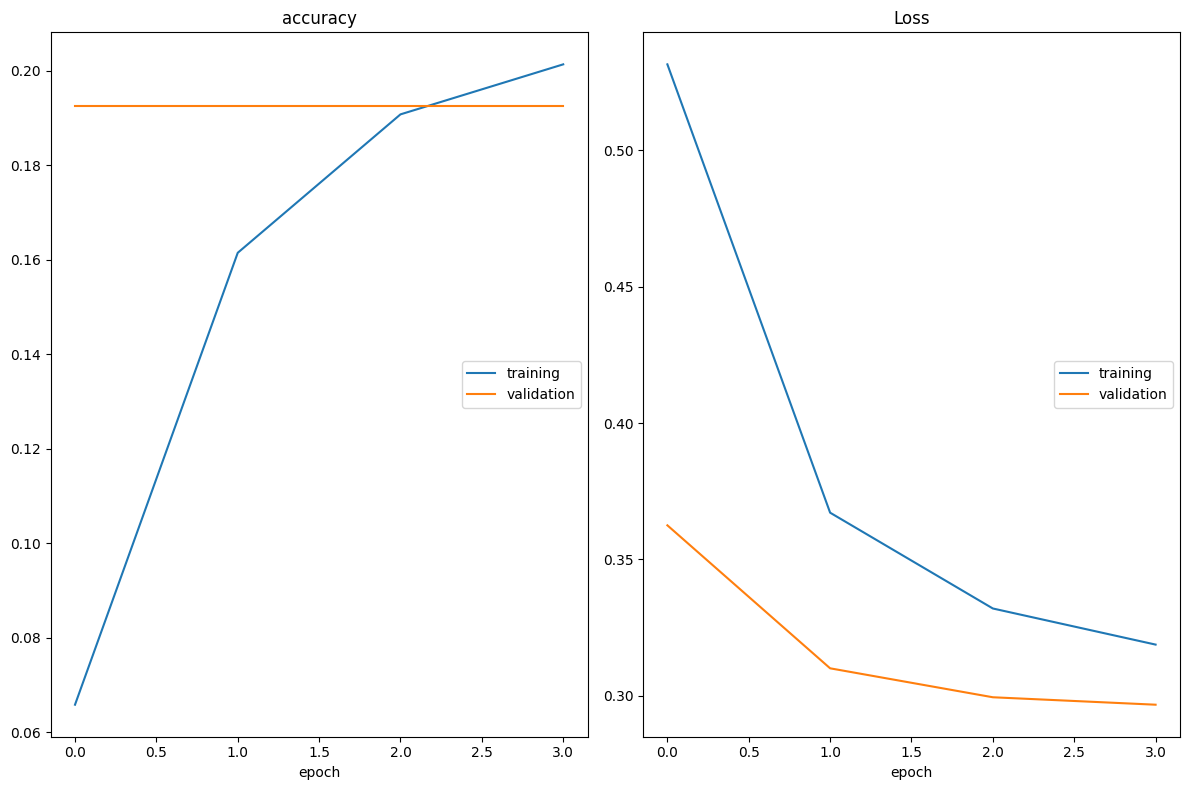

accuracy
	training         	 (min:    0.066, max:    0.201, cur:    0.201)
	validation       	 (min:    0.193, max:    0.193, cur:    0.193)
Loss
	training         	 (min:    0.319, max:    0.532, cur:    0.319)
	validation       	 (min:    0.297, max:    0.362, cur:    0.297)
42/42 - 3s - 73ms/step - accuracy: 0.2014 - loss: 0.3187 - val_accuracy: 0.1926 - val_loss: 0.2967
Epoch 5/100


KeyboardInterrupt: 

In [18]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
# Entrenamiento de la red neuronal usando el set de entrenamiento
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=128, epochs=100, verbose=2,
          callbacks=[PlotLossesKeras()]
)

In [ ]:
# Predicción del modelo de clasificación
y_pred_genres = model.predict(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step


0.49854194564610294

## Testeo del modelo

In [ ]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
res.head()

KeyboardInterrupt: 

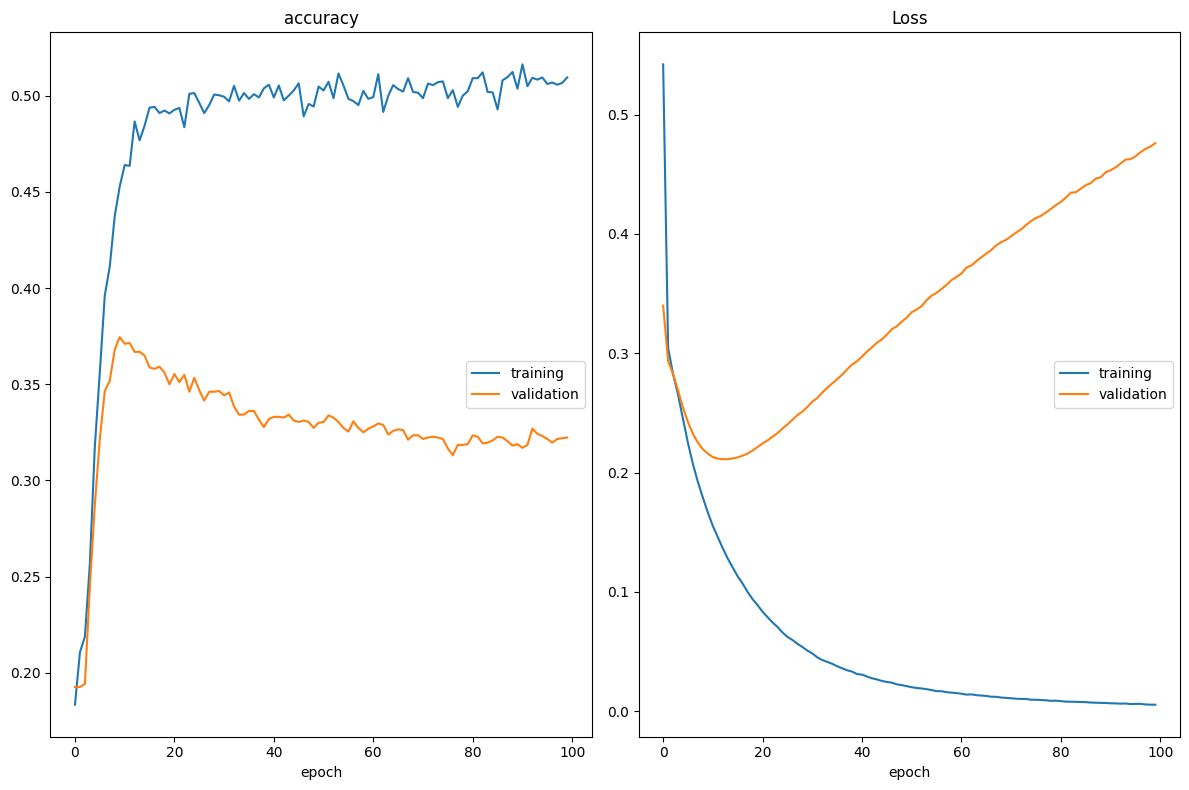

accuracy
	training         	 (min:    0.183, max:    0.516, cur:    0.510)
	validation       	 (min:    0.193, max:    0.375, cur:    0.322)
Loss
	training         	 (min:    0.006, max:    0.542, cur:    0.006)
	validation       	 (min:    0.211, max:    0.476, cur:    0.476)
42/42 - 1s - 31ms/step - accuracy: 0.5095 - loss: 0.0055 - val_accuracy: 0.3223 - val_loss: 0.4761
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ROC AUC Score: 0.8473337481528281


In [ ]:
# Preprocesamiento del texto
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

dataTraining['plot_processed'] = dataTraining['plot'].apply(preprocess_text)

# Vectorización del texto usando TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataTraining['plot_processed']).toarray()

# Binarización de las etiquetas
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definición del modelo
model = Sequential()

model.add(Dense(300, input_dim=5000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Compilación del modelo
model.compile( loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir un callback para TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          batch_size=128, epochs=100, verbose=2,
          callbacks=[PlotLossesKeras()])

# Evaluación del modelo
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred, average='macro')
print("ROC AUC Score:", roc_auc)

In [20]:
# Convertir las etiquetas de géneros a formato binario
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataTraining['genres'])

# Definir la columna de textos
texts = dataTraining['plot'].values

# Definir el vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts).toarray()

# Padding de las secuencias TF-IDF (a veces es necesario convertir a una longitud fija, aunque en este caso, TF-IDF ya genera vectores de longitud fija)
max_sequence_length = X_tfidf.shape[1]
X = pad_sequences(X_tfidf, maxlen=max_sequence_length)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Definición del modelo
model = Sequential()
model.add(Embedding(input_dim=max_sequence_length, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='sigmoid'))  # Para múltiples etiquetas

# Compilación del modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Impresión de la arquitectura del modelo
model.summary()

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=10, verbose=1, callbacks=[PlotLossesKeras()])
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
24/42 ━━━━━━━━━━━━━━━━━━━━ 8:40 29s/step - accuracy: 0.0630 - loss: 0.6260

KeyboardInterrupt: 